In [3]:
"""
Question 1: Are there any oddities that could cause someone problems when using the data to 
answer questions? How would you deal with them?

Answer: 
"""

'\nQuestion 1: Are there any oddities that could cause someone problems when using the data to \nanswer questions? How would you deal with them?\n\nAnswer: \n'

In [1]:
"""
Start Data Prep
"""

# Import libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType as Int, BooleanType as Bool
import seaborn as sns

# Create a spark object. You can visit the spark ui on localhost:4041 if 4040 is unavailable
spark = SparkSession \
        .builder \
        .appName("population_estimates") \
        .getOrCreate()

21/09/03 23:56:51 WARN Utils: Your hostname, DESKTOP-BUTVPC5 resolves to a loopback address: 127.0.1.1; using 172.28.241.207 instead (on interface eth0)
21/09/03 23:56:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/09/03 23:56:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/09/03 23:56:53 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
# Accept the raw data into a spark dataframe
# Ignore records with no Geography and Geography Code, 
# Drop malformed that do not confer to schema, and cache the dataframe in memory for speed
raw_data_path = "Local-Data/population_estimates_rawdata.csv"
pop_df = spark \
    .read \
    .option("header", "True") \
    .csv(raw_data_path, inferSchema=True, mode="DROPMALFORMED") \
    .dropna(how="any", subset=["Geography", "Geography code"]) \
    .cache()

In [3]:
# Clean the dataframe. Preserve the meaning of + by adding a new boolean column age >= 90 with a UDF
@F.udf(returnType=Bool())
def is_above_ninety(age_string):
    if age_string >= 90:
        return True
    return False

cleaned_pop_df = pop_df \
    .withColumn("Age", F.regexp_replace("Age", "\+", "").cast(Int())) \
    .withColumn("Above 90", is_above_ninety("Age"))

"""
End Data Prep
"""

'\nEnd Data Prep\n'

In [4]:
"""
Question 2: Which geography contained the smallest total population in each year from 2013 to 2016?
"""

# Sum populations grouped by Geography for each year
total_pop_by_geo = cleaned_pop_df \
    .select("Geography", "2013", "2014", "2015", "2016") \
    .where("Sex in ('All')") \
    .groupBy("Geography") \
    .agg(F.sum("2013").alias("2013"), F.sum("2014").alias("2014"), F.sum("2015").alias("2015"), F.sum("2016").alias("2016"))

# Select(F.min(year)).head(n=1)[0] returns the minimum value, psuedo subquery, for each year
# 2013 minimum
total_pop_by_geo \
    .select("Geography", "2013") \
    .where(F.col("2013") == total_pop_by_geo.select(F.min('2013')).head()[0]) \
    .show()
# 2014 minimum
total_pop_by_geo \
    .select("Geography", "2014") \
    .where(F.col("2014") == total_pop_by_geo.select(F.min('2014')).head()[0]) \
    .show()
# 2015 minimum
total_pop_by_geo \
    .select("Geography", "2015") \
    .where(F.col("2015") == total_pop_by_geo.select(F.min('2015')).head()[0]) \
    .show()
# 2016 minimum
total_pop_by_geo \
    .select("Geography", "2016") \
    .where(F.col("2016") == total_pop_by_geo.select(F.min('2016')).head()[0]) \
    .show()

# Lowest Pop in 2013: Isles of Scilly
# Lowest Pop in 2014: Isles of Scilly
# Lowest Pop in 2015: Isles of Scilly
# Lowest Pop in 2016: Isles of Scilly


+---------------+----+
|      Geography|2013|
+---------------+----+
|Isles of Scilly|2232|
+---------------+----+

+---------------+----+
|      Geography|2014|
+---------------+----+
|Isles of Scilly|2280|
+---------------+----+

+---------------+----+
|      Geography|2015|
+---------------+----+
|Isles of Scilly|2324|
+---------------+----+

+---------------+----+
|      Geography|2016|
+---------------+----+
|Isles of Scilly|2308|
+---------------+----+



In [5]:
"""
Question 3.1: Which geography had the highest female-to-male ratio in 2013, and what was the ratio?
"""

# Pivot Sex, and compute sum(Females) / sum(Males) for each geography in 2013
# Order descending and show the top value, which is the highest F-M ratio
cleaned_pop_df \
    .select("Geography", "Sex", "2013") \
    .groupBy("Geography") \
    .pivot("Sex") \
    .sum() \
    .withColumn("Ratio", F.col("Female") / F.col("Male")) \
    .select("Geography", "Ratio") \
    .orderBy(F.desc("Ratio")) \
    .limit(1) \
    .show()

# Highest female-to-male ratio in 2013: Knowsley with ~1.10359127

+---------+-----------------+
|Geography|            Ratio|
+---------+-----------------+
| Knowsley|1.103591279555338|
+---------+-----------------+



In [6]:
"""
Question 3.2: Comparing each geography's female-to-male ratio measurements in 2013 vs 2016, which 
changed the most? Which changed the least?
"""

# Pivot Sex for 2013 and 2016, create columns with 2013 F-M Ratio, 2016 F-M Ratio, and the Delta
pop_ratio_delta_df = cleaned_pop_df \
    .select("Geography", "Sex", "2013", "2016") \
    .groupBy("Geography") \
    .pivot("Sex") \
    .sum("2013", "2016") \
    .withColumn("2013 Ratio", F.col("Female_sum(2013)") / F.col("Male_sum(2013)")) \
    .withColumn("2016 Ratio", F.col("Female_sum(2016)") / F.col("Male_sum(2016)")) \
    .withColumn("2013 vs 2016 Delta", F.abs(F.col("2013 Ratio") - F.col("2016 Ratio"))) \

# Most change would be largest ratio delta
pop_ratio_delta_df \
    .select("Geography", "2013 vs 2016 Delta") \
    .orderBy(F.desc("2013 vs 2016 Delta")) \
    .limit(1) \
    .show()

# Least change would be lowest ratio delta
pop_ratio_delta_df \
    .select("Geography", "2013 vs 2016 Delta") \
    .orderBy(F.asc("2013 vs 2016 Delta")) \
    .limit(1) \
    .show()

# Geography with female-to-male ratio that changed the most: Moray with delta=0.0674442377540787
# Geography with female-to-male ratio that changed the least: Winchester with delta=3.11390344611695E-5

+---------+------------------+
|Geography|2013 vs 2016 Delta|
+---------+------------------+
|    Moray|0.0674442377540787|
+---------+------------------+

+----------+-------------------+
| Geography| 2013 vs 2016 Delta|
+----------+-------------------+
|Winchester|3.11390344611695E-5|
+----------+-------------------+



'\nQuestion 4.2: What are the anomalies? Describe the factors that could account for anomalies\n    Anomaly 1: 90 year olds \n    Factors: This is because we are lumping all 90+ into one Age bin\n\n    Anomaly 2: Massive spike in population Age around 75 during a steady decline in population in this Age range\n    Factors: Older people who want to retire probably go to these places because they are peaceful\n\n    Anomaly 3: Dips in teen and mid-life years\n    Factors: People leave these areas to travel other parts of the world\n'

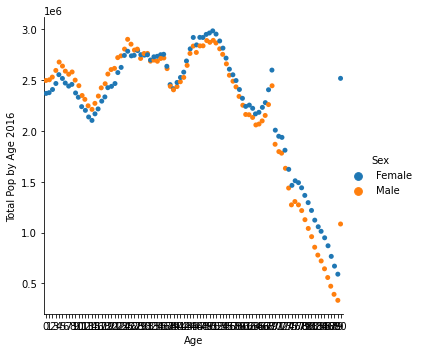

In [7]:
"""
Question 4.1: Plot a visualization of the 2016 age distribution split out by sex
"""

# First, we calculate the distribution by Sex amd Age in 2016
# We convert it to a pandas dataframe to be used with seaborn plots
age_dist_2016_pandas_df = cleaned_pop_df \
    .select("Age", "Sex", "2016") \
    .where("Sex in ('Male', 'Female')") \
    .groupBy("Age", "Sex") \
    .agg(F.sum("2016").alias("Total Pop by Age 2016")) \
    .orderBy(F.desc("Age")) \
    .toPandas()

# Second, we use seaborn to perform catplot to 'split-out' Male dist and Female dist
sns.catplot(data=age_dist_2016_pandas_df, x='Age', y='Total Pop by Age 2016', hue='Sex')

"""
Question 4.2: What are the anomalies? Describe the factors that could account for anomalies
    Anomaly 1: 90 year olds 
    Factors: This is because we are lumping all 90+ into one Age bin

    Anomaly 2: Massive spike in population Age around 75 during a steady decline in population in this Age range
    Factors: Older people who want to retire probably go to these places because they are peaceful

    Anomaly 3: Dips in teen and mid-life years
    Factors: People leave these areas to travel other parts of the world
"""

In [8]:
"""
Question 4.2: The UK population is getting older over time, but according to this dataset, that is not
the case everywhere across the UK. Investigate:
    1. Which geographies have a particularly high or low proportion of over 65s between 2013-2016?

    2. Which geographies show the largest change in proportion of over-65s between 2013-2016?

    3. Are your numerical results realistic?

    4. What factors could explain the outliers?

"""
# TODO: Filter the second aggregate sum
cleaned_pop_df \
    .select("Geography", "Age", "2013", "2014", "2015", "2016") \
    .where("Sex in ('All') ") \
    .groupBy("Geography") \
    .agg(F.sum("2013").alias("Total Pop 2013"), F.sum("2013").alias("Total Pop 2013")) \
    .show()


+--------------------+--------------+--------------+
|           Geography|Total Pop 2013|Total Pop 2013|
+--------------------+--------------+--------------+
|           Worcester|        100405|        100405|
|           Charnwood|        170645|        170645|
|      North Kesteven|        109814|        109814|
|                Arun|        152818|        152818|
|       Epping Forest|        127170|        127170|
|             Waveney|        115962|        115962|
|              Stroud|        113920|        113920|
|              Maldon|         62166|         62166|
|          New Forest|        178062|        178062|
|           Sedgemoor|        117544|        117544|
| Ards and North Down|        157640|        157640|
|           Guildford|        141009|        141009|
|            Worthing|        106117|        106117|
|             Fareham|        113614|        113614|
|         Oxfordshire|        666197|        666197|
|              Bolton|        280057|        2